**Цель проекта**

Нужно построить модель, которая будет определять температуру на поверхностях звезд.

**Характеристики**

- Относительная светимость L/Lo — светимость звезды относительно Солнца.

- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.

- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.

- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

- Тип звезды.
- - Коричневый карлик	- 0

- - Красный карлик	- 1

- - Белый карлик - 2

- - Звёзды главной последовательности -	3

- - Сверхгигант	- 4

- - Гипергигант	- 5


- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

## Импорт библиотек и загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import optuna
import shap
from math import ceil

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from torchmetrics import MeanSquaredError

from catboost import CatBoostRegressor

from skorch import NeuralNetRegressor

In [ ]:
torch.manual_seed(987)
np.random.seed(987)

In [ ]:
sns.set()

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Star Temperature Prediction/6_class_csv.csv")

In [ ]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [ ]:
data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


## Предобработка и исследовательский анализ данных.

Приведем названия столбцов к snake_case.

In [ ]:
data = data.rename(columns={'Temperature (K)': 'temperature', 'Luminosity(L/Lo)': 'luminosity', 'Radius(R/Ro)': 'radius', 'Absolute magnitude(Mv)': 'absolute_magnitude', 'Star type': 'star_type', 'Star color': 'star_color'})

In [ ]:
train_data, test_data = train_test_split(data, train_size=0.8, random_state=987, shuffle=True)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [ ]:
train_data.shape, test_data.shape

((192, 6), (48, 6))

Проверим, нет ли пропусков и дубликатов в данных.

In [ ]:
train_data.isna().sum()

temperature           0
luminosity            0
radius                0
absolute_magnitude    0
star_type             0
star_color            0
dtype: int64

In [ ]:
train_data.duplicated().sum()

0

Дубликатов и пропусков нет.

In [ ]:
train_data['star_color'].unique()

array(['Red', 'Blue-white', 'Blue White', 'Blue', 'yellow-white',
       'Blue white', 'White', 'white', 'Yellowish White',
       'Pale yellow orange', 'Blue-White', 'Yellowish', 'Whitish',
       'yellowish', 'Blue ', 'Orange'], dtype=object)

В фиче star color есть неявные дубликаты. Исправим это.

In [ ]:
def prepare_star_color(color):
  if color == 'Blue ':
    return 'Blue'
  if 'blue' in color.lower() and 'white' in color.lower():
    color = 'Blue-white'
  if 'whit' in color.lower() and 'blue' not in color.lower() and 'yellow' not in color.lower():
    color = 'White'
  if 'white' in color.lower() and 'yellow' in color.lower():
    color = 'Yellow-white'
  if 'yellowish' in color.lower():
    color = 'Yellowish'
  if color == 'Pale yellow orange':
    color = 'Yellow-orange'
  if color == 'Orange-Red':
    color = 'Orange-red'
  return color.lower()

In [ ]:
train_data['star_color'] = train_data['star_color'].apply(prepare_star_color)

In [ ]:
train_data['star_color'].unique()

array(['red', 'blue-white', 'blue', 'yellow-white', 'white',
       'yellow-orange', 'yellowish', 'Blue', 'orange'], dtype=object)

Изучим данные фичу luminosity.

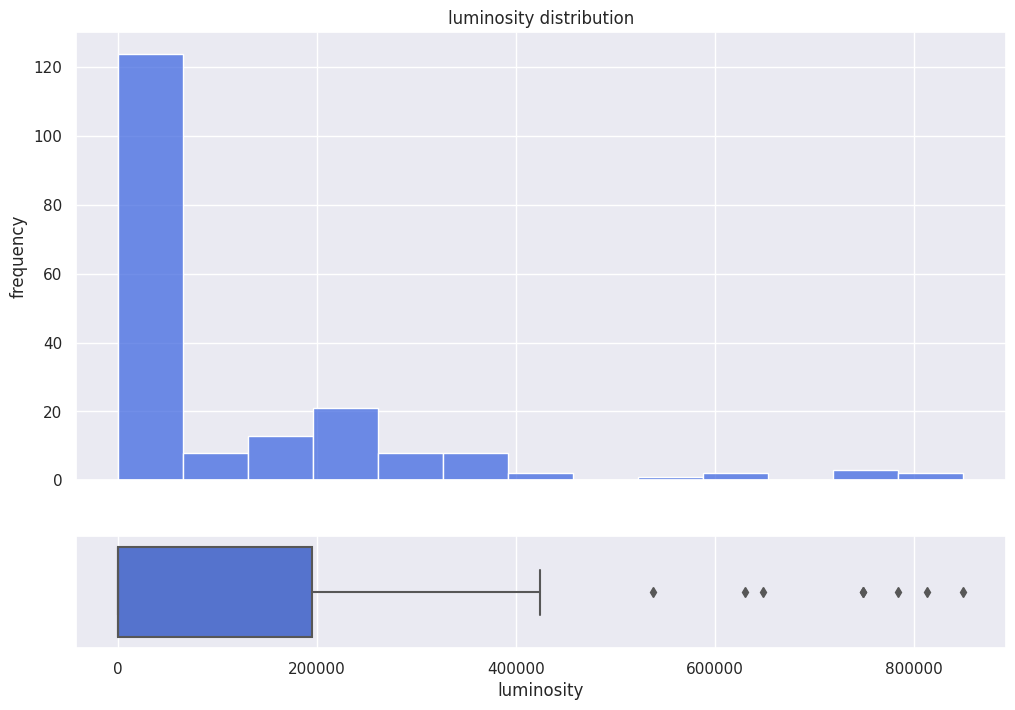

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=train_data['luminosity'], ax=ax_hist, color='royalblue')
sns.boxplot(x=train_data['luminosity'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='luminosity')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='luminosity distribution')
plt.show()

Распределение экспоненциальное.

Столбец содержит выбросы.

In [ ]:
train_data.query('luminosity > 45000')['luminosity'].count()

68

В данном датасете экстремально малое количество данных, по этой причнине не будем удалять выбросы.

Изучим фичу radius.

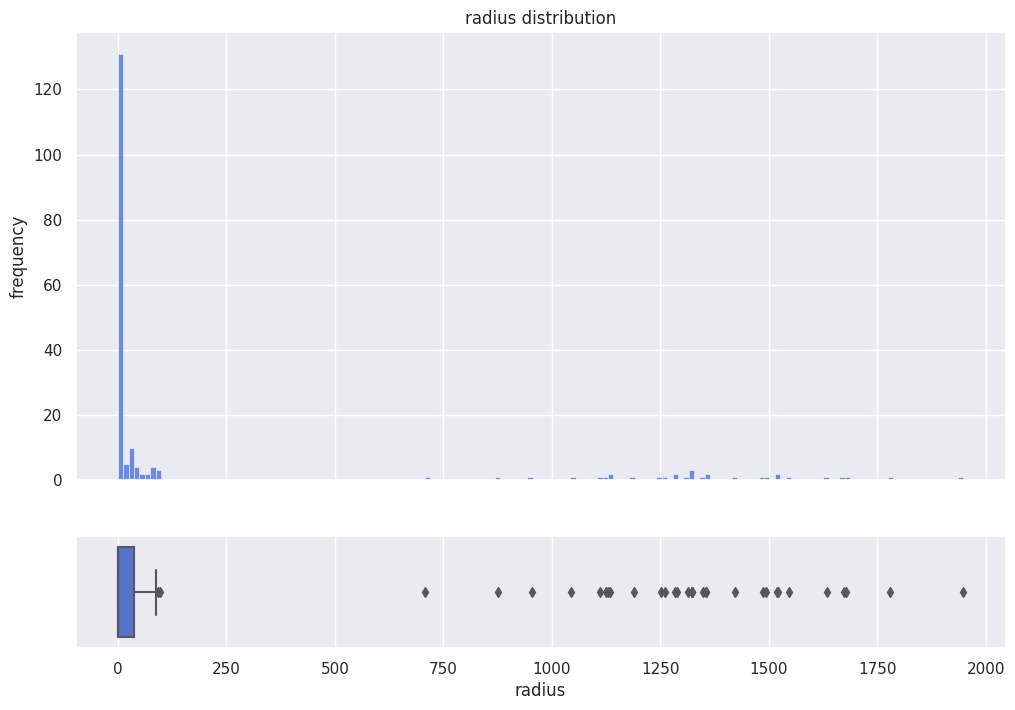

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=train_data['radius'], ax=ax_hist, color='royalblue')
sns.boxplot(x=train_data['radius'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='radius')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='radius distribution')
plt.show()

In [ ]:
train_data.query('radius > 100')['radius'].count()

31

Распределение радиуса экспоненциальное.

Изучим фичу absolute magnitude.

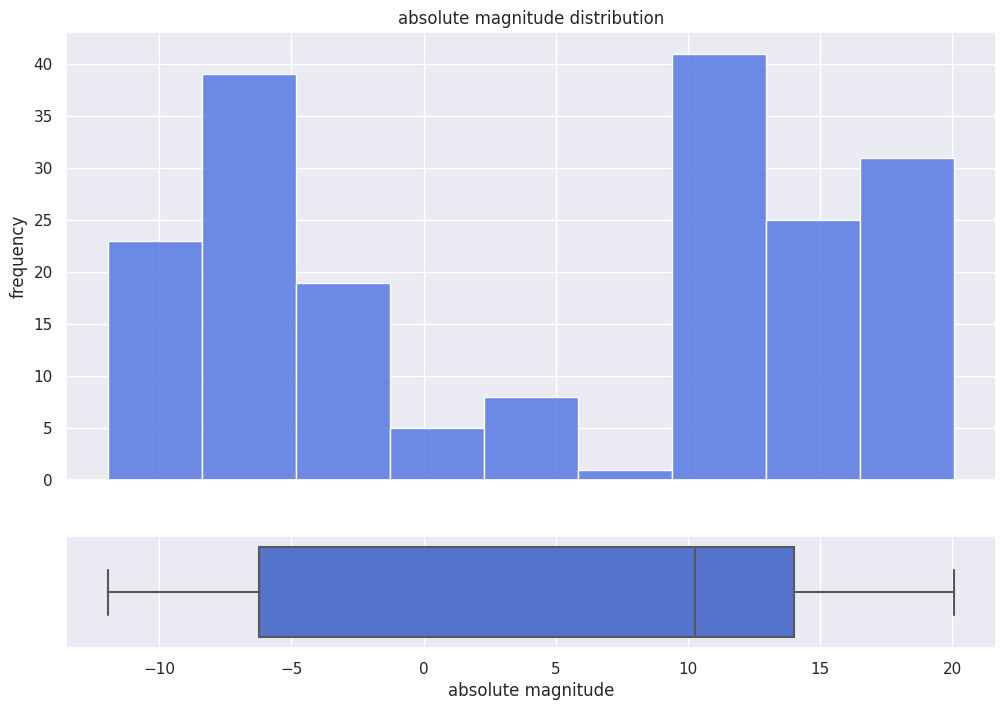

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=train_data['absolute_magnitude'], ax=ax_hist, color='royalblue')
sns.boxplot(x=train_data['absolute_magnitude'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='absolute magnitude')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='absolute magnitude distribution')
plt.show()

Фича не имеет выбросов.

Изучим фичу star type.

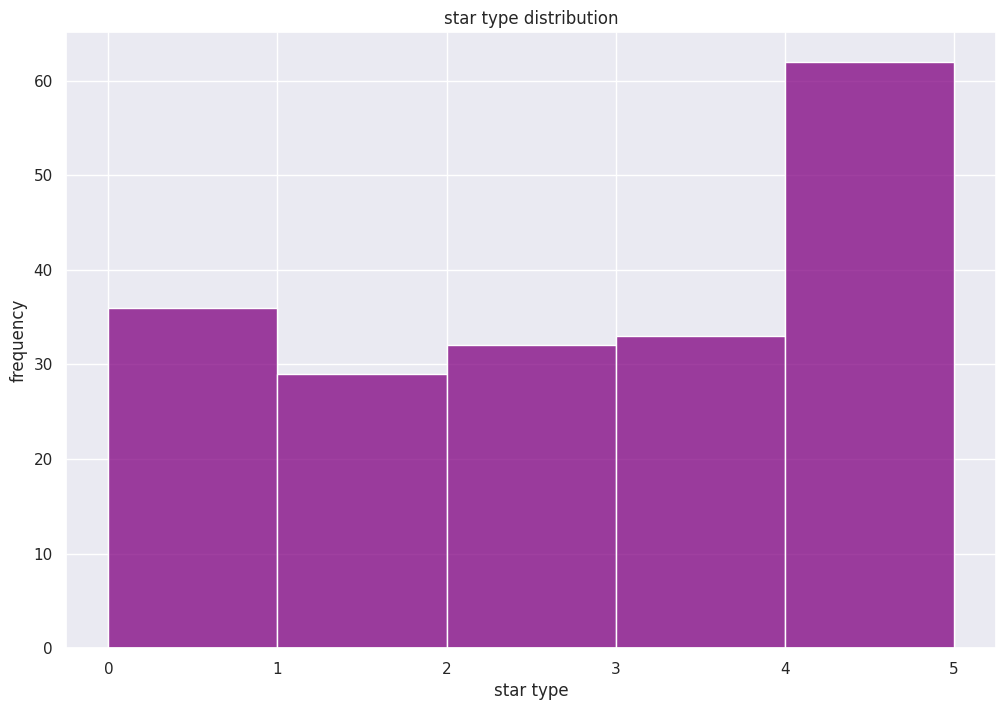

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=train_data['star_type'], ax=ax_hist, color='purple', bins=5)

ax_hist.set(xlabel='star type')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='star type distribution')
plt.show()

В данной фиче так же выбросов нет. Больше всего звезд типа 5, остальные типы распределены почти равномерно.

Изучим фичу star_color.

Большее количество звезд красного, синего, сине-белого цвета, белого и желто-белого цвета. Остальных цветов очень малое количество, их можно объединить в категорию other.

In [ ]:
train_data['star_color'].value_counts()

red              89
blue             43
blue-white       35
white            11
yellow-white      9
yellowish         2
yellow-orange     1
Blue              1
orange            1
Name: star_color, dtype: int64

In [ ]:
color_other_categories = train_data['star_color'].value_counts()[:5].index

In [ ]:
train_data.loc[~train_data['star_color'].isin(color_other_categories), 'star_color'] = 'other'

In [ ]:
train_data['star_color'].value_counts()

red             89
blue            43
blue-white      35
white           11
yellow-white     9
other            5
Name: star_color, dtype: int64

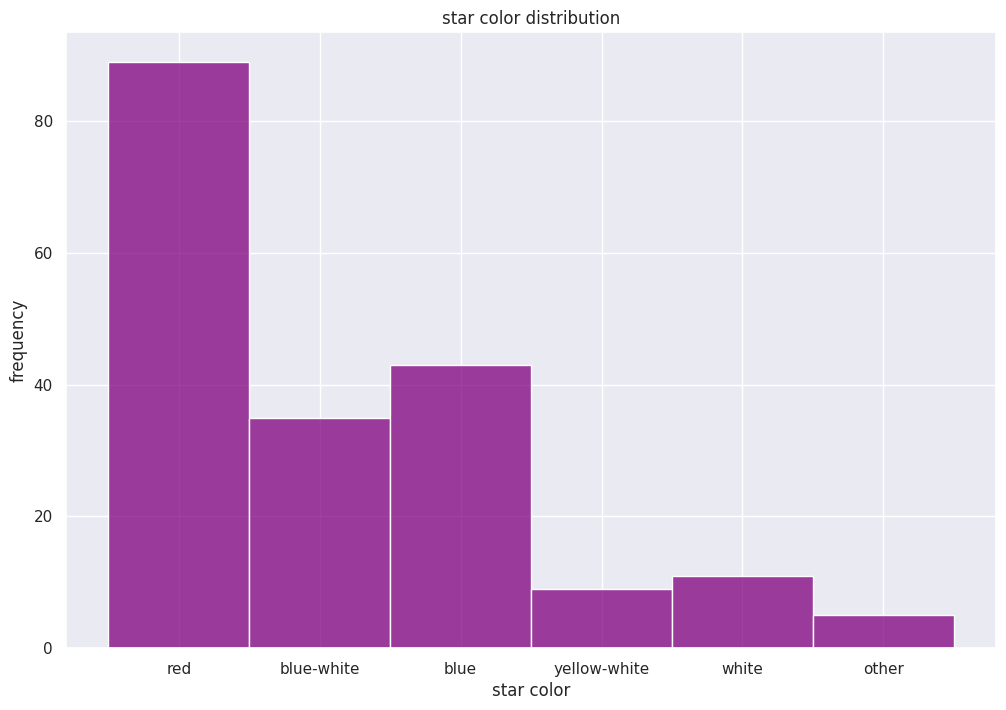

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=train_data['star_color'], ax=ax_hist, color='purple', bins=5)

ax_hist.set(xlabel='star color')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='star color distribution')
plt.show()

Изучим таргет - temperature.

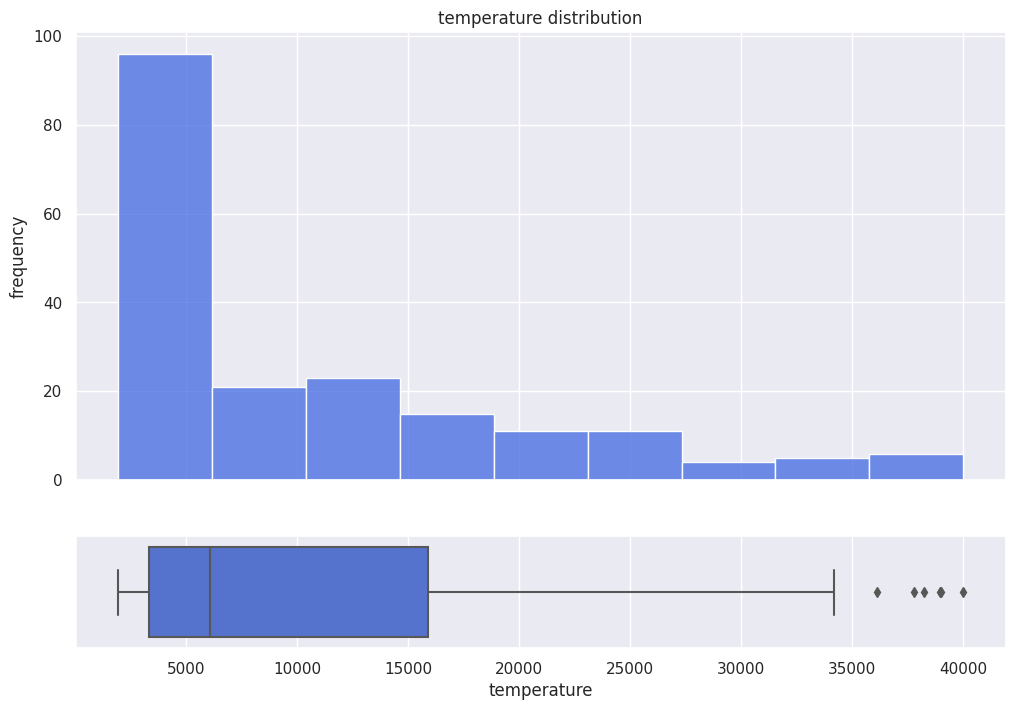

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=train_data['temperature'], ax=ax_hist, color='royalblue')
sns.boxplot(x=train_data['temperature'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='temperature')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='temperature distribution')
plt.show()

In [ ]:
train_data.query('temperature > 30000')['temperature'].count()

11

Таргет распределен экспоненциально.

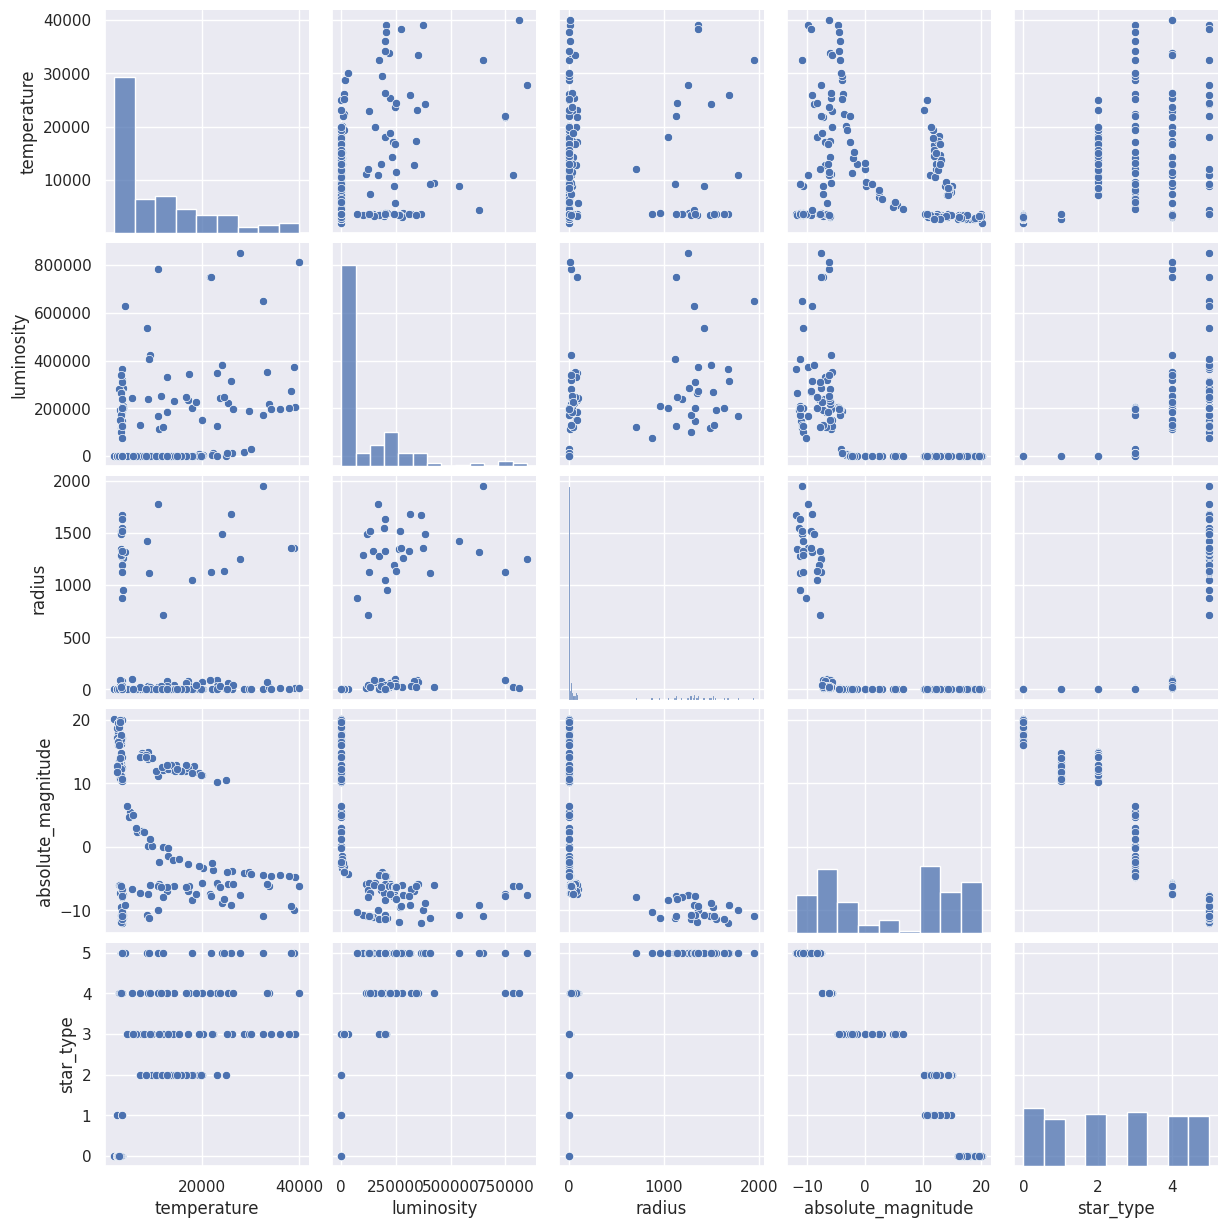

In [ ]:
sns.pairplot(train_data)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

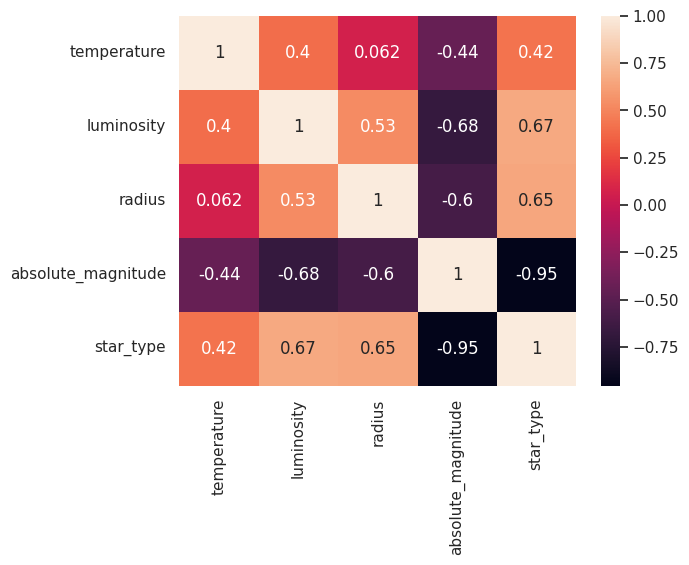

In [ ]:
sns.heatmap(train_data.corr(), annot=True)

На тепловой карте видно, что фича absolute_magnitude достаточно сильно коррелирует со всеми другими фичами, в частности с star_type. Коэффициент корреляции очень большой и это говорит о мультиколлинеарности.

Также значимая корреляция между температурой и: типом звезды и светимостью. Между светимостью и: радиусом и типом звезды.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         192 non-null    int64  
 1   luminosity          192 non-null    float64
 2   radius              192 non-null    float64
 3   absolute_magnitude  192 non-null    float64
 4   star_type           192 non-null    int64  
 5   star_color          192 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 9.1+ KB


## Обучение моделей

Выделим фичи и таргет для каждой из двух выборок.

Не будем выделять валидационноую выборку, так как будем использовать кросс-валидацию.

In [ ]:
x_train = train_data.drop(columns=['temperature'], axis=1)
y_train = train_data['temperature']

In [ ]:
x_train.shape, y_train.shape

((192, 5), (192,))

Напишем функцию предобработки тестовой выборки.

In [ ]:
def test_sample_preprocessing(df):
  df['star_color'] = df['star_color'].apply(prepare_star_color)
  df.loc[~df['star_color'].isin(color_other_categories), 'star_color'] = 'other'

  return df

In [ ]:
test_data = test_sample_preprocessing(test_data)

In [ ]:
x_test = test_data.drop(columns=['temperature'], axis=1)
y_test = test_data['temperature']

Для начала попробуем использовать модель линейной регрессии

Применим к датасету OheHotEncoder и StandardScaler

In [ ]:
cat_features = ['star_type', 'star_color']
num_features = ['luminosity', 'radius', 'absolute_magnitude']

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [ ]:
x_train_ohe = pd.DataFrame(ohe.fit_transform(x_train[cat_features]), columns=ohe.get_feature_names_out())
x_train_ohe[num_features] = x_train[num_features]

In [ ]:
x_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   star_type_1              192 non-null    float64
 1   star_type_2              192 non-null    float64
 2   star_type_3              192 non-null    float64
 3   star_type_4              192 non-null    float64
 4   star_type_5              192 non-null    float64
 5   star_color_blue-white    192 non-null    float64
 6   star_color_other         192 non-null    float64
 7   star_color_red           192 non-null    float64
 8   star_color_white         192 non-null    float64
 9   star_color_yellow-white  192 non-null    float64
 10  luminosity               192 non-null    float64
 11  radius                   192 non-null    float64
 12  absolute_magnitude       192 non-null    float64
dtypes: float64(13)
memory usage: 19.6 KB


In [ ]:
st_scaler = StandardScaler()

In [ ]:
x_train_ohe_st = pd.DataFrame(st_scaler.fit_transform(x_train_ohe), columns=x_train_ohe.columns)

In [ ]:
x_test_ohe = pd.DataFrame(ohe.transform(x_test[cat_features]), columns=ohe.get_feature_names_out())
x_test_ohe[num_features] = x_test[num_features]
x_test_ohe_st = pd.DataFrame(st_scaler.transform(x_test_ohe), columns=x_test_ohe.columns)
x_test = x_test_ohe_st

In [ ]:
lin_reg = LinearRegression()

In [ ]:
abs(cross_val_score(lin_reg, x_train_ohe_st, y_train, scoring='neg_root_mean_squared_error', cv=5)).mean()

5088.190388148758

На трейне линейная регрессия дала RMSE = 5088.

Теперь попробуем использовать CatBoost.

Для этого применим порядковое кодирование.

In [ ]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [ ]:
x_train_ord = pd.DataFrame(ord_enc.fit_transform(x_train[cat_features]), columns=cat_features)
x_train_ord[num_features] = x_train[num_features]

In [ ]:
x_train_ord.head()

,star_type,star_color,luminosity,radius,absolute_magnitude
0,1.0,3.0,0.001500,0.3070,11.87
1,1.0,3.0,0.001300,0.2560,14.33
2,1.0,3.0,0.008500,0.1800,13.20
3,0.0,3.0,0.000621,0.0773,17.08
4,3.0,1.0,16790.000000,6.4000,-4.09


In [ ]:
cat_boost = CatBoostRegressor(verbose=250, random_state=987)

In [ ]:
abs(cross_val_score(cat_boost, x_train_ord, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

Learning rate set to 0.030434
0:	learn: 9095.0401306	total: 48.2ms	remaining: 48.2s
250:	learn: 2372.7755108	total: 516ms	remaining: 1.54s
500:	learn: 1407.0350222	total: 1.14s	remaining: 1.13s
750:	learn: 855.6382102	total: 1.66s	remaining: 551ms
999:	learn: 557.2868167	total: 2.21s	remaining: 0us
Learning rate set to 0.030434
0:	learn: 9648.4996631	total: 14.8ms	remaining: 14.8s
250:	learn: 2606.7848685	total: 549ms	remaining: 1.64s
500:	learn: 1516.1304588	total: 1.02s	remaining: 1.02s
750:	learn: 989.2751856	total: 1.56s	remaining: 517ms
999:	learn: 659.2648500	total: 1.9s	remaining: 0us
Learning rate set to 0.030465
0:	learn: 9700.4036343	total: 3.01ms	remaining: 3.01s
250:	learn: 2363.0950844	total: 425ms	remaining: 1.27s
500:	learn: 1459.8917853	total: 559ms	remaining: 557ms
750:	learn: 906.1825692	total: 716ms	remaining: 237ms
999:	learn: 574.4430631	total: 870ms	remaining: 0us
Learning rate set to 0.030465
0:	learn: 9835.0902916	total: 883us	remaining: 883ms
250:	learn: 2478.4

4568.355630658107

Градиентный бустинг на трейне дал значительно лучший результат - 4568.

In [ ]:
x_test.head()

,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue-white,star_color_other,star_color_red,star_color_white,star_color_yellow-white,luminosity,radius,absolute_magnitude
0,-0.421799,-0.447214,-0.455573,-0.438801,2.278936,-0.472155,6.115554,-0.929558,-0.246523,-0.221766,2.584740,2.851210,-1.180264
1,2.370799,-0.447214,-0.455573,-0.438801,-0.438801,-0.472155,-0.163517,1.075780,-0.246523,-0.221766,-0.588604,-0.448697,0.963990
2,-0.421799,-0.447214,-0.455573,2.278936,-0.438801,-0.472155,-0.163517,-0.929558,-0.246523,-0.221766,2.838030,-0.288812,-1.106285
3,2.370799,-0.447214,-0.455573,-0.438801,-0.438801,-0.472155,-0.163517,1.075780,-0.246523,-0.221766,-0.588604,-0.447555,0.960235
4,-0.421799,-0.447214,2.195036,-0.438801,-0.438801,2.117950,-0.163517,-0.929558,-0.246523,-0.221766,-0.581231,-0.437643,-0.736204


Попробуем для решения задачи использовать различные архитектуры нейронных сетей.

Используем разные нейронные сети с 1, 2 и 3 скрытыми слоями. Выясним, при каком количестве нейронов в каждом слое модель показывает наилучшие результаты.

In [ ]:
x_train = torch.FloatTensor(x_train_ohe_st.values)
y_train = torch.FloatTensor(y_train.values).reshape(y_train.shape[0], 1)

x_test = torch.FloatTensor(x_test_ohe_st.values)
y_test = torch.FloatTensor(y_test.values).reshape(y_test.shape[0], 1)

In [ ]:
n_in_neurons = x_train.shape[1]
n_out_neurons = 1

In [ ]:
mean_squared_error = MeanSquaredError(squared=False)
loss = nn.MSELoss()

In [ ]:
for n_hidden_neurons_1 in range(500, 1501, 50):
  net = nn.Sequential(
      nn.Linear(n_in_neurons, n_hidden_neurons_1),
      nn.ReLU(),
      nn.Linear(n_hidden_neurons_1, n_out_neurons),
      nn.ReLU()
  )

  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

  num_epochs = 1000

  for epoch in range(num_epochs):
    optimizer.zero_grad()

    preds = net.forward(x_train)

    loss_value = loss(preds, y_train)
    loss_value.backward()

    optimizer.step()

  net.eval()
  rmse = mean_squared_error(net.forward(x_test), y_test)
  print(f"h1: {n_hidden_neurons_1} rmse: {rmse}")

h1: 500 rmse: 10282.2431640625
h1: 550 rmse: 10067.166015625
h1: 600 rmse: 9833.859375
h1: 650 rmse: 9636.2392578125
h1: 700 rmse: 9418.2431640625
h1: 750 rmse: 9224.8173828125
h1: 800 rmse: 9064.8564453125
h1: 850 rmse: 8871.25
h1: 900 rmse: 8705.376953125
h1: 950 rmse: 8552.322265625
h1: 1000 rmse: 8428.462890625
h1: 1050 rmse: 8313.521484375
h1: 1100 rmse: 8162.25927734375
h1: 1150 rmse: 8029.806640625
h1: 1200 rmse: 7930.189453125
h1: 1250 rmse: 7843.1806640625
h1: 1300 rmse: 7751.0556640625
h1: 1350 rmse: 7665.6240234375
h1: 1400 rmse: 7590.3916015625
h1: 1450 rmse: 7519.08203125
h1: 1500 rmse: 7462.3525390625


В сети с одним скрытым слоем с увеличением в нем количества нейронов результат предсказания улучшается. Лучший скор был получен при 1500 нейронах в скрытом слое. Он составляет 7462.

Обучим сеть с двумя скрытыми слоями с перебором количества нейронов.

In [ ]:
samples = 25
h1 = list(range(200, 800, 50))
h2 = list(range(200, 800, 50))

In [ ]:
for i in range(samples):
    n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
    n_hidden_neurons_2 = h1[np.random.randint(0, len(h2))]

    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.Tanh(),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_2, n_out_neurons),
        nn.ReLU()
    )

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    num_epochs = 1000

    for epoch in range(num_epochs):
      optimizer.zero_grad()

      preds = net.forward(x_train)

      loss_value = loss(preds, y_train)
      loss_value.backward()

      optimizer.step()

    net.eval()
    rmse = mean_squared_error(net.forward(x_test), y_test)
    print(f"h1: {n_hidden_neurons_1} h2: {n_hidden_neurons_2} rmse: {rmse}")

h1: 350 h2: 550 rmse: 4210.49560546875
h1: 650 h2: 500 rmse: 4183.3388671875
h1: 350 h2: 500 rmse: 4205.845703125
h1: 700 h2: 450 rmse: 4152.78857421875
h1: 700 h2: 350 rmse: 4183.865234375
h1: 700 h2: 300 rmse: 4135.27490234375
h1: 350 h2: 650 rmse: 4194.40283203125
h1: 350 h2: 700 rmse: 4227.08447265625
h1: 200 h2: 700 rmse: 4165.94287109375
h1: 500 h2: 250 rmse: 4143.7568359375
h1: 250 h2: 700 rmse: 4226.8505859375
h1: 650 h2: 600 rmse: 4229.8330078125
h1: 750 h2: 500 rmse: 4225.05712890625
h1: 700 h2: 650 rmse: 4235.1865234375
h1: 700 h2: 350 rmse: 4872.47607421875
h1: 300 h2: 550 rmse: 4121.880859375
h1: 300 h2: 700 rmse: 4223.46630859375
h1: 300 h2: 750 rmse: 4208.09765625
h1: 600 h2: 350 rmse: 4156.5087890625
h1: 550 h2: 450 rmse: 4216.4736328125
h1: 550 h2: 650 rmse: 4195.18359375
h1: 350 h2: 200 rmse: 4232.4169921875
h1: 300 h2: 550 rmse: 4153.98681640625
h1: 450 h2: 550 rmse: 4236.193359375
h1: 300 h2: 650 rmse: 4170.8984375


Метрика сети с двумя скрытыми слоями намного лучше, достигает 4121 RMSE. Лучший результат получился при 300 нейронах в первом и 550 нейронах во втором скрытых слоях.

Теперь попробуем обучить сеть с тремя скрытыми слоями.

In [ ]:
samples = 15
h1 = list(range(200, 800, 50))
h2 = list(range(200, 800, 50))
h3 = list(range(300, 700, 50))

In [ ]:
for i in range(samples):
      n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
      n_hidden_neurons_2 = h1[np.random.randint(0, len(h2))]
      n_hidden_neurons_3 = h1[np.random.randint(0, len(h3))]

      net = nn.Sequential(
          nn.Linear(n_in_neurons, n_hidden_neurons_1),
          nn.Tanh(),
          nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
          nn.ReLU(),
          nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
          nn.ReLU(),
          nn.Linear(n_hidden_neurons_3, n_out_neurons),
          nn.ReLU()
      )

      optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

      num_epochs = 1000

      for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = net.forward(x_train)

        loss_value = loss(preds, y_train)
        loss_value.backward()

        optimizer.step()

      net.eval()
      rmse = mean_squared_error(net.forward(x_test), y_test)
      print(f"h1: {n_hidden_neurons_1} h2: {n_hidden_neurons_2} h3: {n_hidden_neurons_3} rmse: {rmse}")

h1: 550 h2: 350 h3: 550 rmse: 13270.4912109375
h1: 300 h2: 450 h3: 250 rmse: 4349.40673828125
h1: 750 h2: 200 h3: 450 rmse: 4456.10693359375
h1: 600 h2: 250 h3: 200 rmse: 4376.58154296875
h1: 350 h2: 450 h3: 550 rmse: 4386.41357421875
h1: 650 h2: 750 h3: 300 rmse: 4459.14599609375
h1: 350 h2: 550 h3: 300 rmse: 4443.55810546875
h1: 350 h2: 550 h3: 250 rmse: 4454.7138671875
h1: 550 h2: 450 h3: 450 rmse: 4468.1171875
h1: 700 h2: 450 h3: 500 rmse: 13270.4912109375
h1: 500 h2: 400 h3: 550 rmse: 4490.279296875
h1: 700 h2: 700 h3: 250 rmse: 4476.92578125
h1: 650 h2: 200 h3: 450 rmse: 4407.4609375
h1: 650 h2: 400 h3: 250 rmse: 4424.1240234375
h1: 500 h2: 700 h3: 400 rmse: 4439.2685546875


Сеть с тремя скрытыми слоями лучше, чем с одним, но хуже, чем с двумя.

Поэтому остановимся на сети с двумя скртыми слоями с 300 нейронами в первом и 550 во втором скрытых слоях.

Обучим лучшую модель используя кросс-валидацию.

In [ ]:
n_hidden_neurons_1 = 300
n_hidden_neurons_2 = 550

In [ ]:
model = nn.Sequential(
          nn.Linear(n_in_neurons, n_hidden_neurons_1),
          nn.Tanh(),
          nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
          nn.ReLU(),
          nn.Linear(n_hidden_neurons_2, n_out_neurons),
          nn.ReLU()
      )

In [ ]:
net = NeuralNetRegressor(
    model,
    criterion= MeanSquaredError(squared=False),
    max_epochs=1000,
    optimizer=torch.optim.Adam,
    optimizer__lr=1e-3,
    callbacks='disable'
)

In [ ]:
scores = cross_val_score(net, x_train, y_train,
                     scoring='neg_mean_squared_error')
s = 0
for i in range(len(scores)):
    s += (-scores[i]) ** 0.5
print('mean rmse: ', s / len(scores))

mean rmse:  4957.185820505076


RMSE на кросс-валидации равна 4957.

Попробуем обучить лучшую сеть батчами, так же добавим дропаут.

In [ ]:
dropout_values = [0.25, 0.5, 0.75]
batch_values = [40, 30, 20, 10]

In [ ]:
for dp in dropout_values:
  for batch_size in batch_values:
    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.Tanh(),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Dropout(p=dp),
        nn.Linear(n_hidden_neurons_2, n_out_neurons),
        nn.ReLU()
    )

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    num_epochs = 1000

    num_batches = ceil(len(x_train) / batch_size)

    for epoch in range(num_epochs):

      shuffled = np.random.permutation(len(x_train))

      for batch_idx in range(num_batches):

        start_index = batch_idx * batch_size

        optimizer.zero_grad()

        batch_indexes = shuffled[start_index: start_index+batch_size]
        x_batch = x_train[start_index: start_index+batch_size]
        y_batch = y_train[start_index: start_index+batch_size]

        preds = net.forward(x_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    net.eval()
    rmse = mean_squared_error(net.forward(x_test), y_test)
    print(f"dropout: {dp} batch size: {batch_size} rmse: {rmse}")

dropout: 0.25 batch size: 40 rmse: 4224.9033203125
dropout: 0.25 batch size: 30 rmse: 4359.298828125
dropout: 0.25 batch size: 20 rmse: 4310.3388671875
dropout: 0.25 batch size: 10 rmse: 4027.125
dropout: 0.5 batch size: 40 rmse: 4185.5556640625
dropout: 0.5 batch size: 30 rmse: 4318.1279296875
dropout: 0.5 batch size: 20 rmse: 4266.68115234375
dropout: 0.5 batch size: 10 rmse: 4000.030517578125
dropout: 0.75 batch size: 40 rmse: 4159.1201171875
dropout: 0.75 batch size: 30 rmse: 4325.2451171875
dropout: 0.75 batch size: 20 rmse: 4260.48876953125
dropout: 0.75 batch size: 10 rmse: 3992.1279296875


При дропауте 0.75 и размере батча в 10 строк сеть получила наилучший результат RMSE = 3992.

Обучим модель с этими параметрами.

In [ ]:
batch_size = 10
dropout = 0.75

In [ ]:
results = np.array([])

In [ ]:
model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Dropout(p=dropout),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
    )

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 1000
num_batches = ceil(len(x_train)/batch_size)

for epoch in range(num_epochs):

    shuffled = np.random.permutation(len(x_train))

    for batch_idx in range(num_batches):

        start_index = batch_idx * batch_size
        optimizer.zero_grad()

        batch_indexes = shuffled[start_index:start_index+batch_size]
        x_batch = x_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = model.forward(x_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    if epoch % 10 == 0:
        test_preds = model.forward(x_test)
        rmse = mean_squared_error(test_preds, y_test)
        results = np.append(results, rmse.detach().numpy())

model.eval()
test_preds = model.forward(x_test)
rmse = mean_squared_error(test_preds, y_test)
results = np.append(results, rmse.detach().numpy())
print(rmse.data)

tensor(4390.2349)


На тестовой выборке RMSE = 4390, что является намного лучшим результатом по сравнению с сетью без дропаута и обучения батчами.

In [ ]:
preds = pd.DataFrame(test_preds.detach().numpy(), columns=['temperature'])
target = pd.DataFrame(y_test.detach().numpy(), columns=['temperature'])

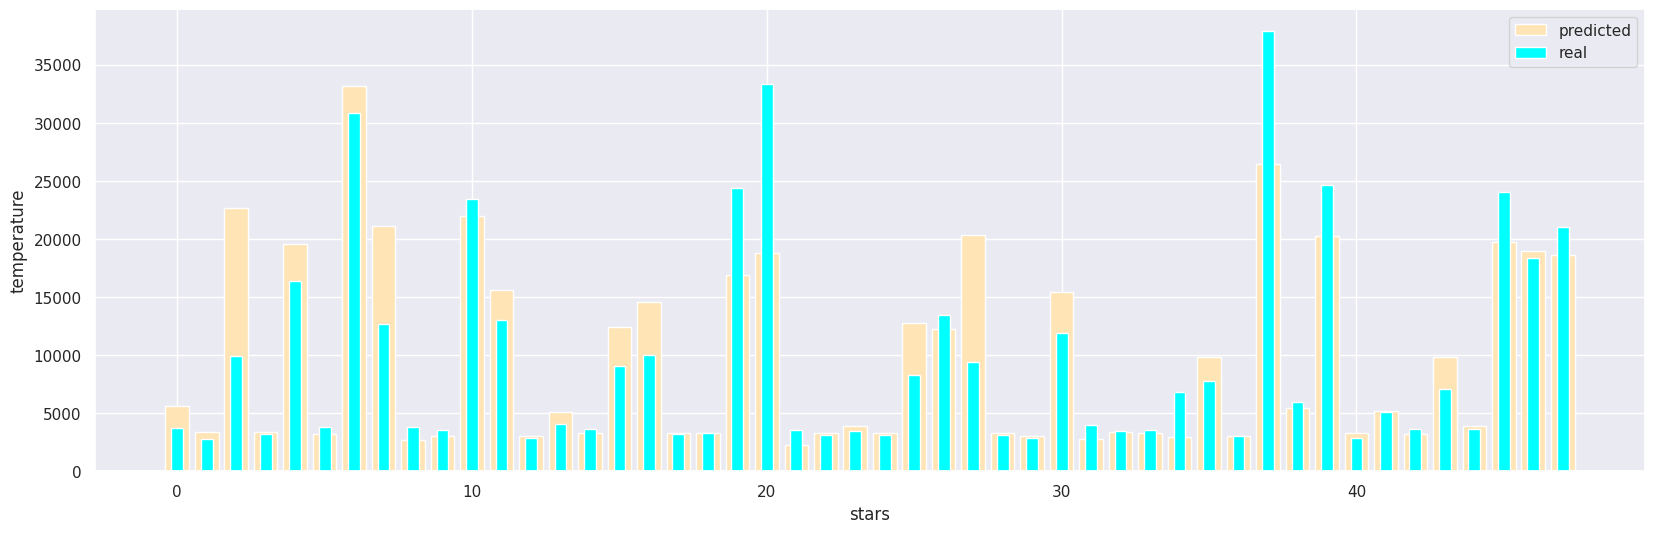

In [ ]:
fig, ax = plt.subplots(figsize=[20,6])
plt.bar(x=preds.index, height=preds['temperature'], color='moccasin' , label='predicted')
plt.bar(x=target.index, height=target['temperature'], color='cyan', label='real', width= 0.4)
plt.xlabel('stars')
plt.ylabel('temperature')
ax.legend()
plt.show()

На графике видно, что сеть достаточно точно предсказывает относительно малые температуры, и менее точно большие температуры.

In [ ]:
epochs = np.arange(0,1001,10)

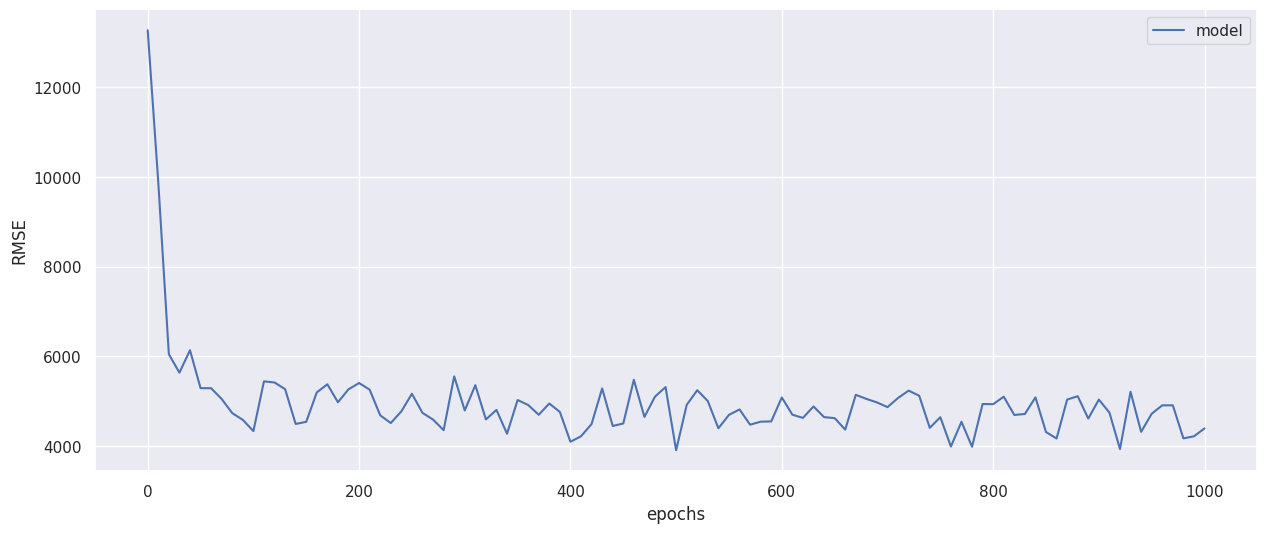

In [ ]:
fig, ax = plt.subplots(figsize=[15,6])
sns.lineplot(x=epochs, y=results, label='model')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.show()

График обучения по эпохам показывает, что сеть достигла минимум функции потерь после 100 эпох обучения, и после этого уменьшение функции потерь не происходило.

**Вывод**

**Были проведены предобработка и исследовательский анализ данных показателей звезд. Затем были построены модели линейной регрессии и градиентного бустинга, последняя из которых дала хороший результат RMSE = 4568.**

**После этого были обучены нейронные сети с разными архитектурами и значениями параметров, была выбрана и простестирована на тестовых данных наилучшая сеть. Она показаа значение метрики RMSE = 4390. Таким образом для данной задачи нейронная сеть показала себя лучше других моделей.**